In [1]:
#pip install quantecon

In [1]:
import numpy as np
import math
from scipy.optimize import fsolve
from quantecon.markov.approximation import tauchen
import matplotlib.pyplot as plt
from scipy import interpolate

In [43]:
# Define parameter values
θ = .21
ν = .64
δ = .1
β = .96
φ = .5
ρ = .9
σ = .02
N_rep = .6   # assume steady state labor supply from rep. household
tol = 1e-6
ϵ = tauchen(ρ,σ,0,3,11)

In [55]:
'''
------------------------------------------------------------------------
Steady state functions
------------------------------------------------------------------------
'''

# Firm labor demand given w and k
n_star = lambda ν,θ,ϵ,w,k: (k>0)*(w/(math.exp(ϵ)*ν*k**θ))**(1/(ν-1))
# Derivative of firm profit wrt k
π_k = lambda ν,θ,ϵ,w,k: θ*math.exp(ϵ)*k**(θ-1)*(w/(ν*math.exp(ϵ)*k**θ))**(ν/(ν-1))
# Derivative of value function V wrt k
V_k = lambda ν,θ,δ,φ,ϵ,w,k: π_k(ν,θ,ϵ,w,k) - φ/2*δ**2+(φ-1)*δ+1

# Left hand side of firm FOC
def foc(k,w,parameters):
    β,ν,θ,δ,φ,ϵ = parameters
    foc_lhs = -1-φ*δ + β*V_k(ν,θ,δ,φ,ϵ,w,k)
    return foc_lhs

# Solve for steady state capital given w
def get_Kss(w,parameters):
    kss = fsolve(foc,.1,args=(w,parameters))
    return kss

# Solve the steady state capital and w
def excess_labor_supply(w,parameters):
    β,ν,θ,δ,φ,N_rep = parameters
    k = get_Kss(w,[β,ν,θ,δ,φ,0])
    n = n_star(ν,θ,0,w,k)
    n_excess = N_rep - n
    return n_excess


# Value function iteration
def VFI(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    
    nϵ,nk = len(ϵ.state_values),len(k_grid)
    V = np.zeros((nϵ*nk,1))
    max_diff = np.inf
    niter = 1
    
    while max_diff > tol:
        ev = np.zeros((nϵ*nk,1))
        for iϵ in range(nϵ):
            for ik in range(nk):
                idx = iϵ*nk + ik 
                idxp = np.arange(ik,nϵ*nk+ik,nk)
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                
        tempV, gk = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1), np.zeros((nϵ*nk,1))        
        for iϵ,ϵ_curr in enumerate(ϵ.state_values):
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik 
                
                vv = (1-δ)*k
                for ikp,kp in enumerate(k_grid):
                    idxp = iϵ*nk + ikp
                    investment = kp - (1-δ)*k
                    v_temp = π(ν,θ,ϵ_curr,w,k) - investment - φ/2*(investment/k)**2 -cf + β*ev[idxp]
                    
                    if v_temp > vv:
                        vv = v_temp
                        tempV[idx] = v_temp
                        gk[idx] = kp
                        
        max_diff = max(np.abs(V-tempV))
        V = tempV
        if niter == 1 or niter % 50 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk

def euler_solvek(kp,ikp,gk,w,ν,θ,β,φ,δ,ϵ,iϵ):
    E_Vk = 0
    nϵ = len(ϵ.state_values)
    nk = np.int(len(gk) / nϵ)
    
    for iϵp,ϵp in enumerate(ϵ.state_values):
        idxp = iϵp*nk + ikp 
        E_Vk = E_Vk + ϵ.P[iϵ,iϵp]*(π_k(ν,θ,ϵp,w,kp)+(1-δ)-φ/2*((gk[idxp]/kp-(1-δ))**2-2*gk[idxp]/kp*(gk[idxp]/kp-(1-δ))))
       
    if kp != 0:
        k = kp / (1/φ * (β*E_Vk-1) + 1-δ)
    else:
        k = 0
    
    return k
                

In [56]:
# Solve for representative agent steady state
w = 1
parameters = [β,ν,θ,δ,φ,N_rep]
wss = fsolve(excess_labor_supply,.25,args=parameters)
kss = get_Kss(wss,[β,ν,θ,δ,φ,0])

k_grid = np.linspace([1e-3],[5],50)
parameters = [ν,θ,δ,φ,tol]

In [57]:
# Solve for incumbent firm's decision rules
cf = .01
V,kp = VFI(cf,wss,k_grid,parameters,ϵ)

Iteration 1: max diff = 5.2436817
Iteration 50: max diff = 0.0153600
Iteration 100: max diff = 0.0019826
Iteration 150: max diff = 0.0002575
Iteration 200: max diff = 0.0000334
Iteration 250: max diff = 0.0000043


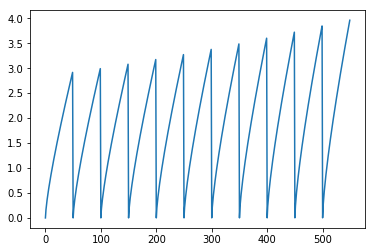

In [58]:
plt.plot(gk)

In [49]:
# Endogenous grid method for incumbent firm's decision rules
def EGM(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    
    nϵ,nk = len(ϵ.state_values),len(k_grid)
    k_end = np.zeros((nϵ*nk,1))
    
    max_diff = np.inf
    niter = 1
    
    # Guess value functions
    V_e = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    V_tilde = V_e + np.ones((nϵ,1)).dot(np.linspace(-.1,.1,nk).reshape(1,nk)).reshape(nϵ*nk,1)
    V = np.maximum(V_tilde-cf,V_e)

    # Guess a policy function of k' defined on the original grid
    gk = np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    
    while max_diff > tol:

        ev = np.zeros((nϵ*nk,1))
        for iϵ in range(nϵ):
            for ik in range(nk):
                idx = iϵ*nk + ik 
                idxp = np.arange(ik,nϵ*nk+ik,nk)
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                        
#         k_end = k1_end * (V_tilde - cf < V_e) + k2_end *(V_tilde - cf >= V_e)
#         V_tilde_end,V_tilde_new = np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1))
        k_end,V_tilde_end,V_tilde_new = np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1))
        
        for iϵ, ϵ_curr in enumerate(ϵ.state_values):
            grid_range = np.arange(iϵ*nk,iϵ*nk+nk,1)
            ev_interp = interpolate.interp1d(k_grid.reshape(nk,),ev[grid_range].reshape(nk,),fill_value='extrapolate')
            
            # Iterate over k'
            ik_cutoff = -np.inf
            for ikp,kp in enumerate(k_grid):
                idxp = iϵ*nk + ikp 
                k = euler_solvek(kp,ikp,gk,w,ν,θ,β,φ,δ,ϵ,iϵ)
                k_end[idxp] = k
                if k != 0:
                    V_tilde_end[idxp] = π(ν,θ,ϵ_curr,w,k) - (kp-(1-δ)*k) - φ/2*(kp/k-(1-δ))**2 *k + β*ev_interp(k)
                else:
                    V_tilde_end[idxp] = - (kp-(1-δ)*k) + β*ev_interp(k)
                    
                if V_tilde_end[idxp] - cf < (1-δ)*k:
                    ik_cutoff = ikp
                        
            V_tilde_end_interp = interpolate.interp1d(k_end[grid_range].reshape(nk,),V_tilde_end[grid_range].reshape(nk,),fill_value='extrapolate')
            gk_interp = interpolate.interp1d(k_end[grid_range].reshape(nk,),k_grid.reshape(nk,),fill_value='extrapolate')
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik                
                V_tilde_new[idx] = V_tilde_end_interp(k)
                
#                 if ik <= ik_cutoff:
#                     gk[idx] = 0                    
#                 else:
#                     gk[idx] = gk_interp(k)   
                gk[idx] = gk_interp(k)
        
#         V_new = np.maximum(V_tilde_new-cf,V_e)
#         max_diff = max(np.abs(V_new-V))
#         V = V_new.copy()
        V_new = V_tilde_new.copy()
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        if niter == 1 or niter % 50 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1

    return V,gk

In [50]:
cf = .01
parameters = ν,θ,δ,φ,tol
V,gk = EGM(cf,wss,k_grid,parameters,ϵ)


Iteration 1: max diff = 0.8557027
Iteration 50: max diff = 0.2144091
Iteration 100: max diff = 0.0278195
Iteration 150: max diff = 0.0036133
Iteration 200: max diff = 0.0004693
Iteration 250: max diff = 0.0000610
Iteration 300: max diff = 0.0000079
Iteration 350: max diff = 0.0000010


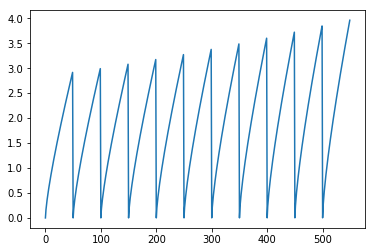

In [54]:
plt.plot(gk)